# Modeling Interest Rates and Derivates

In [1]:
import math

import matplotlib.pyplot as plt

from fkit_bond import *

## A Simple Python Zero-Coupon Bond Calculator

In [2]:
print(zero_coupon_bond(100, 0.05, 5))

78.35261664684589


## Bootstrapping A Yield Curve

In [3]:
yield_curve = BootstrapYieldCurve()
yield_curve.add_instrument(100, 0.25, 0.0, 97.5)
yield_curve.add_instrument(100, 0.5, 0.0, 94.9)
yield_curve.add_instrument(100, 1.0, 0.0, 90.0)
yield_curve.add_instrument(100, 1.5, 8, 96.0, 2)
yield_curve.add_instrument(100, 2.0, 12, 101.6, 2)

In [4]:
y = yield_curve.get_zero_rates()
x = yield_curve.get_maturities()

[Text(0.5, 0, 'Maturity in Years'),
 Text(0, 0.5, 'Zero Rate (%)'),
 Text(0.5, 1.0, 'Zero Curve')]

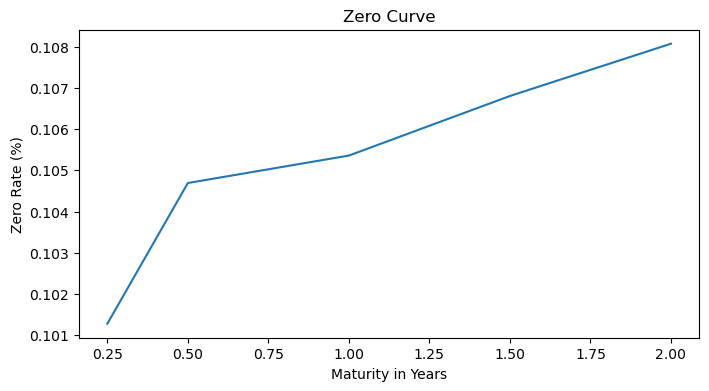

In [5]:
_, ax = plt.subplots(figsize=(8, 4))

ax.plot(x, y)
ax.set(xlabel="Maturity in Years", ylabel="Zero Rate (%)", title="Zero Curve")

## Forward Rates

In [6]:
fr = ForwardRates()
fr.add_spot_rate(0.25, 10.127)
fr.add_spot_rate(0.50, 10.469)
fr.add_spot_rate(1.00, 10.536)
fr.add_spot_rate(1.50, 10.681)
fr.add_spot_rate(2.00, 10.808)
print(fr.get_forward_rates())

[10.810999999999998, 10.603, 10.971, 11.189]


## Calculating The Yield To Maturity

In [7]:
ytm = bond_ytm(95.0428, 100, 1.5, 5.75, 2)
print(ytm)

0.09369155345239477


## Calculating the price of a bond

In [8]:
price = bond_price(100, 1.5, ytm, 5.75, 2)
print(price)

95.04280000000004


## Bond Duration

In [9]:
mod_duration = bond_mod_duration(95.0428, 100, 1.5, 5.75, 2)
print(mod_duration)

1.3921935426560885


## Bond Convexity

## Short-Rate Modeling

### The Vasicek Model

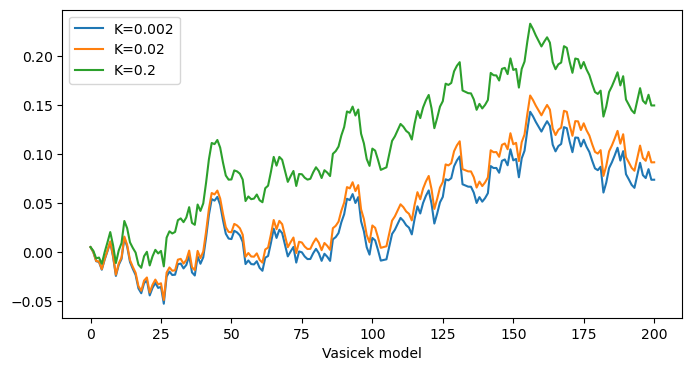

In [10]:
_, ax = plt.subplots(figsize=(8, 4))

for K in [0.002, 0.02, 0.2]:
    x, y = vasicek(0.005, K, 0.15, 0.05, T=10, N=200)
    ax.plot(x, y, label=f"K={K}")

ax.set(xlabel="Vasicek model")
ax.legend(loc="upper left")

### The Cox-Ingersoll-Ross Model

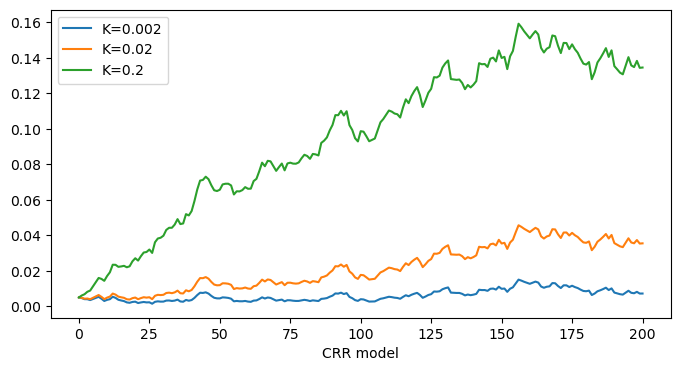

In [11]:
_, ax = plt.subplots(figsize=(8, 4))

for K in [0.002, 0.02, 0.2]:
    x, y = CIR(0.005, K, 0.15, 0.05, T=10, N=200)
    ax.plot(x, y, label=f"K={K}")

ax.set(xlabel="CRR model")
ax.legend(loc="upper left")

### The Rendleman And Bartter Model

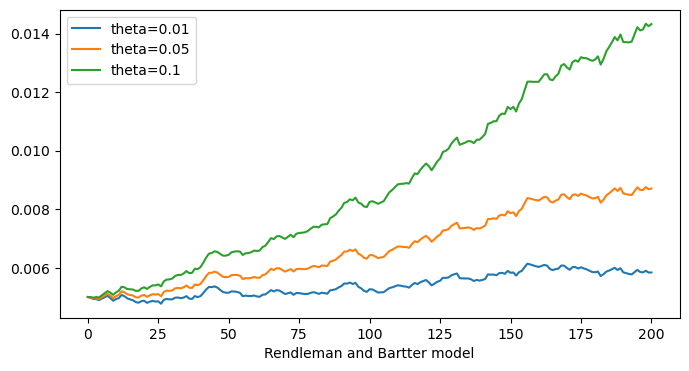

In [12]:
_, ax = plt.subplots(figsize=(8, 4))

for theta in [0.01, 0.05, 0.1]:
    x, y = rendleman_bartter(0.005, theta, 0.05, T=10, N=200)
    ax.plot(x, y, label=f"theta={theta}")

ax.set(xlabel="Rendleman and Bartter model")
ax.legend(loc="upper left")

### The Brennan And Schwartz Model

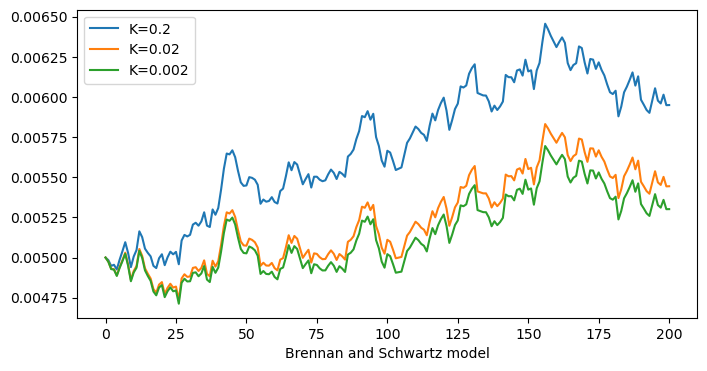

In [13]:
_, ax = plt.subplots(figsize=(8, 4))

for K in [0.2, 0.02, 0.002]:
    x, y = brennan_schwartz(0.005, K, 0.006, 0.05, T=10, N=200)
    ax.plot(x, y, label=f"K={K}")

ax.set(xlabel="Brennan and Schwartz model")
ax.legend(loc="upper left")

## Pricing A Callable Bond Option

### Pricing A Zero-Coupon Bond By The Vasicek Model

In [14]:
def exact_zcb(theta, kappa, sigma, tau, r0=0.0):
    B = (1 - np.exp(-kappa * tau)) / kappa
    A = np.exp(
        (theta - (sigma**2) / (2 * (kappa**2))) * (B - tau)
        - (sigma**2) / (4 * kappa) * (B**2)
    )
    return A * np.exp(-r0 * B)

In [15]:
Ts = np.r_[0.0:25.5:0.5]
zcbs = [exact_zcb(0.5, 0.02, 0.03, t, 0.015) for t in Ts]

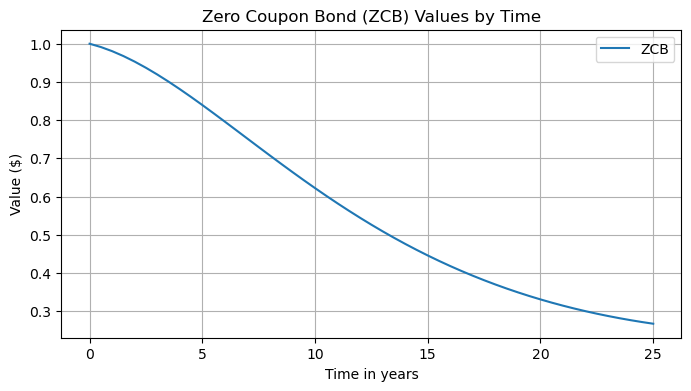

In [16]:
_, ax = plt.subplots(figsize=(8, 4))

ax.plot(Ts, zcbs, label="ZCB")
ax.set(
    xlabel="Time in years",
    ylabel="Value ($)",
    title="Zero Coupon Bond (ZCB) Values by Time",
)
ax.legend()
ax.grid(True)

## Value of Early-Exercise

In [17]:
def exercise_value(K, R, t):
    return K * math.exp(-R * t)

In [18]:
Ts = np.r_[0.0:25.5:0.5]
Ks = [exercise_value(0.95, 0.015, t) for t in Ts]
zcbs = [exact_zcb(0.5, 0.02, 0.03, t, 0.015) for t in Ts]

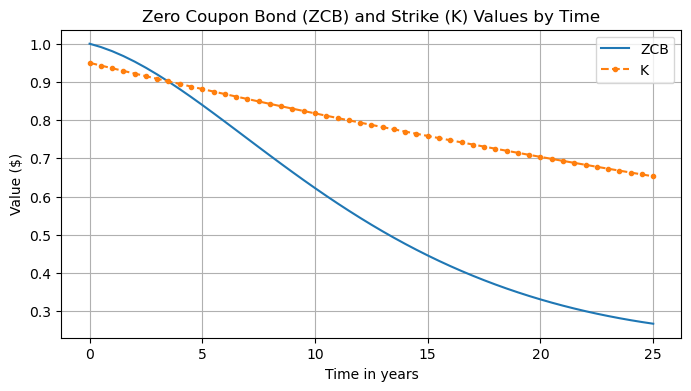

In [19]:
_, ax = plt.subplots(figsize=(8, 4))

ax.plot(Ts, zcbs, label="ZCB")
ax.plot(Ts, Ks, label="K", linestyle="--", marker=".")
ax.set(
    xlabel="Time in years",
    ylabel="Value ($)",
    title="Zero Coupon Bond (ZCB) and Strike (K) Values by Time",
)
ax.legend()
ax.grid(True)

## Policy Iteration By Finite Differences


In [20]:
r0 = 0.05
R = 0.05
ratio = 0.95
sigma = 0.03
kappa = 0.15
theta = 0.05
prob = 1e-6
M = 250
max_policy_iter = 10
grid_struct_interval = 0.25
rs = np.r_[0.0:2.0:0.1]

In [21]:
vasicek = VasicekCZCB()
r, vals = vasicek.vasicek_czcb_values(
    r0,
    R,
    ratio,
    1.0,
    sigma,
    kappa,
    theta,
    M,
    prob,
    max_policy_iter,
    grid_struct_interval,
    rs,
)

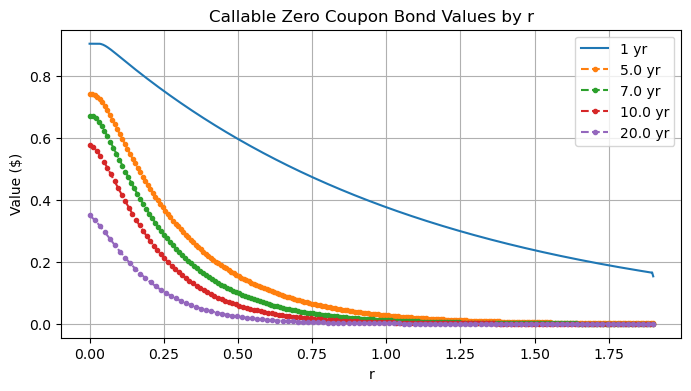

In [22]:
_, ax = plt.subplots(figsize=(8, 4))


ax.plot(r, vals, label="1 yr")
for T in [5.0, 7.0, 10.0, 20.0]:
    r, vals = vasicek.vasicek_czcb_values(
        r0,
        R,
        ratio,
        T,
        sigma,
        kappa,
        theta,
        M,
        prob,
        max_policy_iter,
        grid_struct_interval,
        rs,
    )
    ax.plot(r, vals, label=f"{T} yr", linestyle="--", marker=".")

ax.set(xlabel="r", ylabel="Value ($)", title="Callable Zero Coupon Bond Values by r")
ax.legend()
ax.grid(True)